In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from lib.functions_data import ordered_countries_original, ordered_countries_new

In [2]:
import sys
from pathlib import Path
import os
cwd = os.getcwd()
parent = str(Path(cwd).parents[0])
sys.path.append(parent)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
#Removing these for low number of trials
ordered_countries_new.remove('Malta - ADM')
ordered_countries_new.remove('Luxembourg - Ministry of Health')
ordered_countries_new.remove('Cyprus - MoH-Ph.S')

In [16]:
usecols = ['eudract_number', 'nca', 'entered_year', 'trial_results']
reporting_by_country = pd.read_csv(parent + '/data/analysis_df_jul22.csv', usecols = usecols)
reporting_by_country['results_dummy'] = np.where(reporting_by_country.trial_results == 'View results', 1, 0)

In [17]:
trial_reporting = reporting_by_country[['eudract_number', 'results_dummy']].groupby('eudract_number').sum()
trial_reporting = trial_reporting.join(reporting_by_country.groupby('eudract_number').count()[['nca']])
trial_reporting = trial_reporting.join(reporting_by_country[['eudract_number', 'entered_year']].groupby('eudract_number').max()[['entered_year']])
trial_reporting['results_dummy'] = np.where(trial_reporting.results_dummy > 0, 1, 0)

In [18]:
single_cta = trial_reporting[trial_reporting.nca == 1][['entered_year', 'results_dummy']].groupby('entered_year').agg(['sum', 'count'])
single_cta['reporting_prct'] = round((single_cta.results_dummy['sum'] / single_cta.results_dummy['count']) * 100, 2)

In [28]:
single_cta

results_dummy       reporting_prct
                       sum count               
entered_year                                   
2004                   161   276          58.33
2005                   818  1440          56.81
2006                   807  1606          50.25
2007                   864  2079          41.56
2008                   763  1862          40.98
2009                   828  1980          41.82
2010                   790  1766          44.73
2011                   696  1371          50.77
2012                   725  1646          44.05
2013                   598  1309          45.68
2014                   544  1230          44.23
2015                   575  1347          42.69
2016                   467  1166          40.05
2017                   339  1060          31.98
2018                   270  1197          22.56
2019                   167  1116          14.96
2020                   128  1430           8.95
2021                    21  1591           1.32
2022                     1   282           0.35

In [19]:
multi_cta = trial_reporting[trial_reporting.nca > 1][['entered_year', 'results_dummy']].groupby('entered_year').agg(['sum', 'count'])
multi_cta['reporting_prct'] = round((multi_cta.results_dummy['sum'] / multi_cta.results_dummy['count']) * 100, 2)

In [20]:
all_trial_reporting = trial_reporting[['entered_year', 'results_dummy']].groupby('entered_year').agg(['sum', 'count'])
all_trial_reporting['reporting_prct'] = round((all_trial_reporting.results_dummy['sum'] / all_trial_reporting.results_dummy['count']) * 100, 2)

In [21]:
print(len(trial_reporting[trial_reporting.nca == 1]))
print(len(trial_reporting[trial_reporting.nca > 1]))
print(len(trial_reporting))

25754
15489
41243


In [22]:
print(trial_reporting[trial_reporting.nca == 1].results_dummy.sum())
print(6259/23623)

9562
0.2649536468695763


In [23]:
print(trial_reporting[trial_reporting.nca > 1].results_dummy.sum())
print(8423/13897)

9915
0.6061020364107361


In [24]:
trial_reporting.results_dummy.sum()

19477

In [25]:
trial_reporting[trial_reporting.nca == 1].results_dummy.sum()
print(6259/14682)

0.42630431821277753


# Overall reporting trend - Supplemental Figure 11

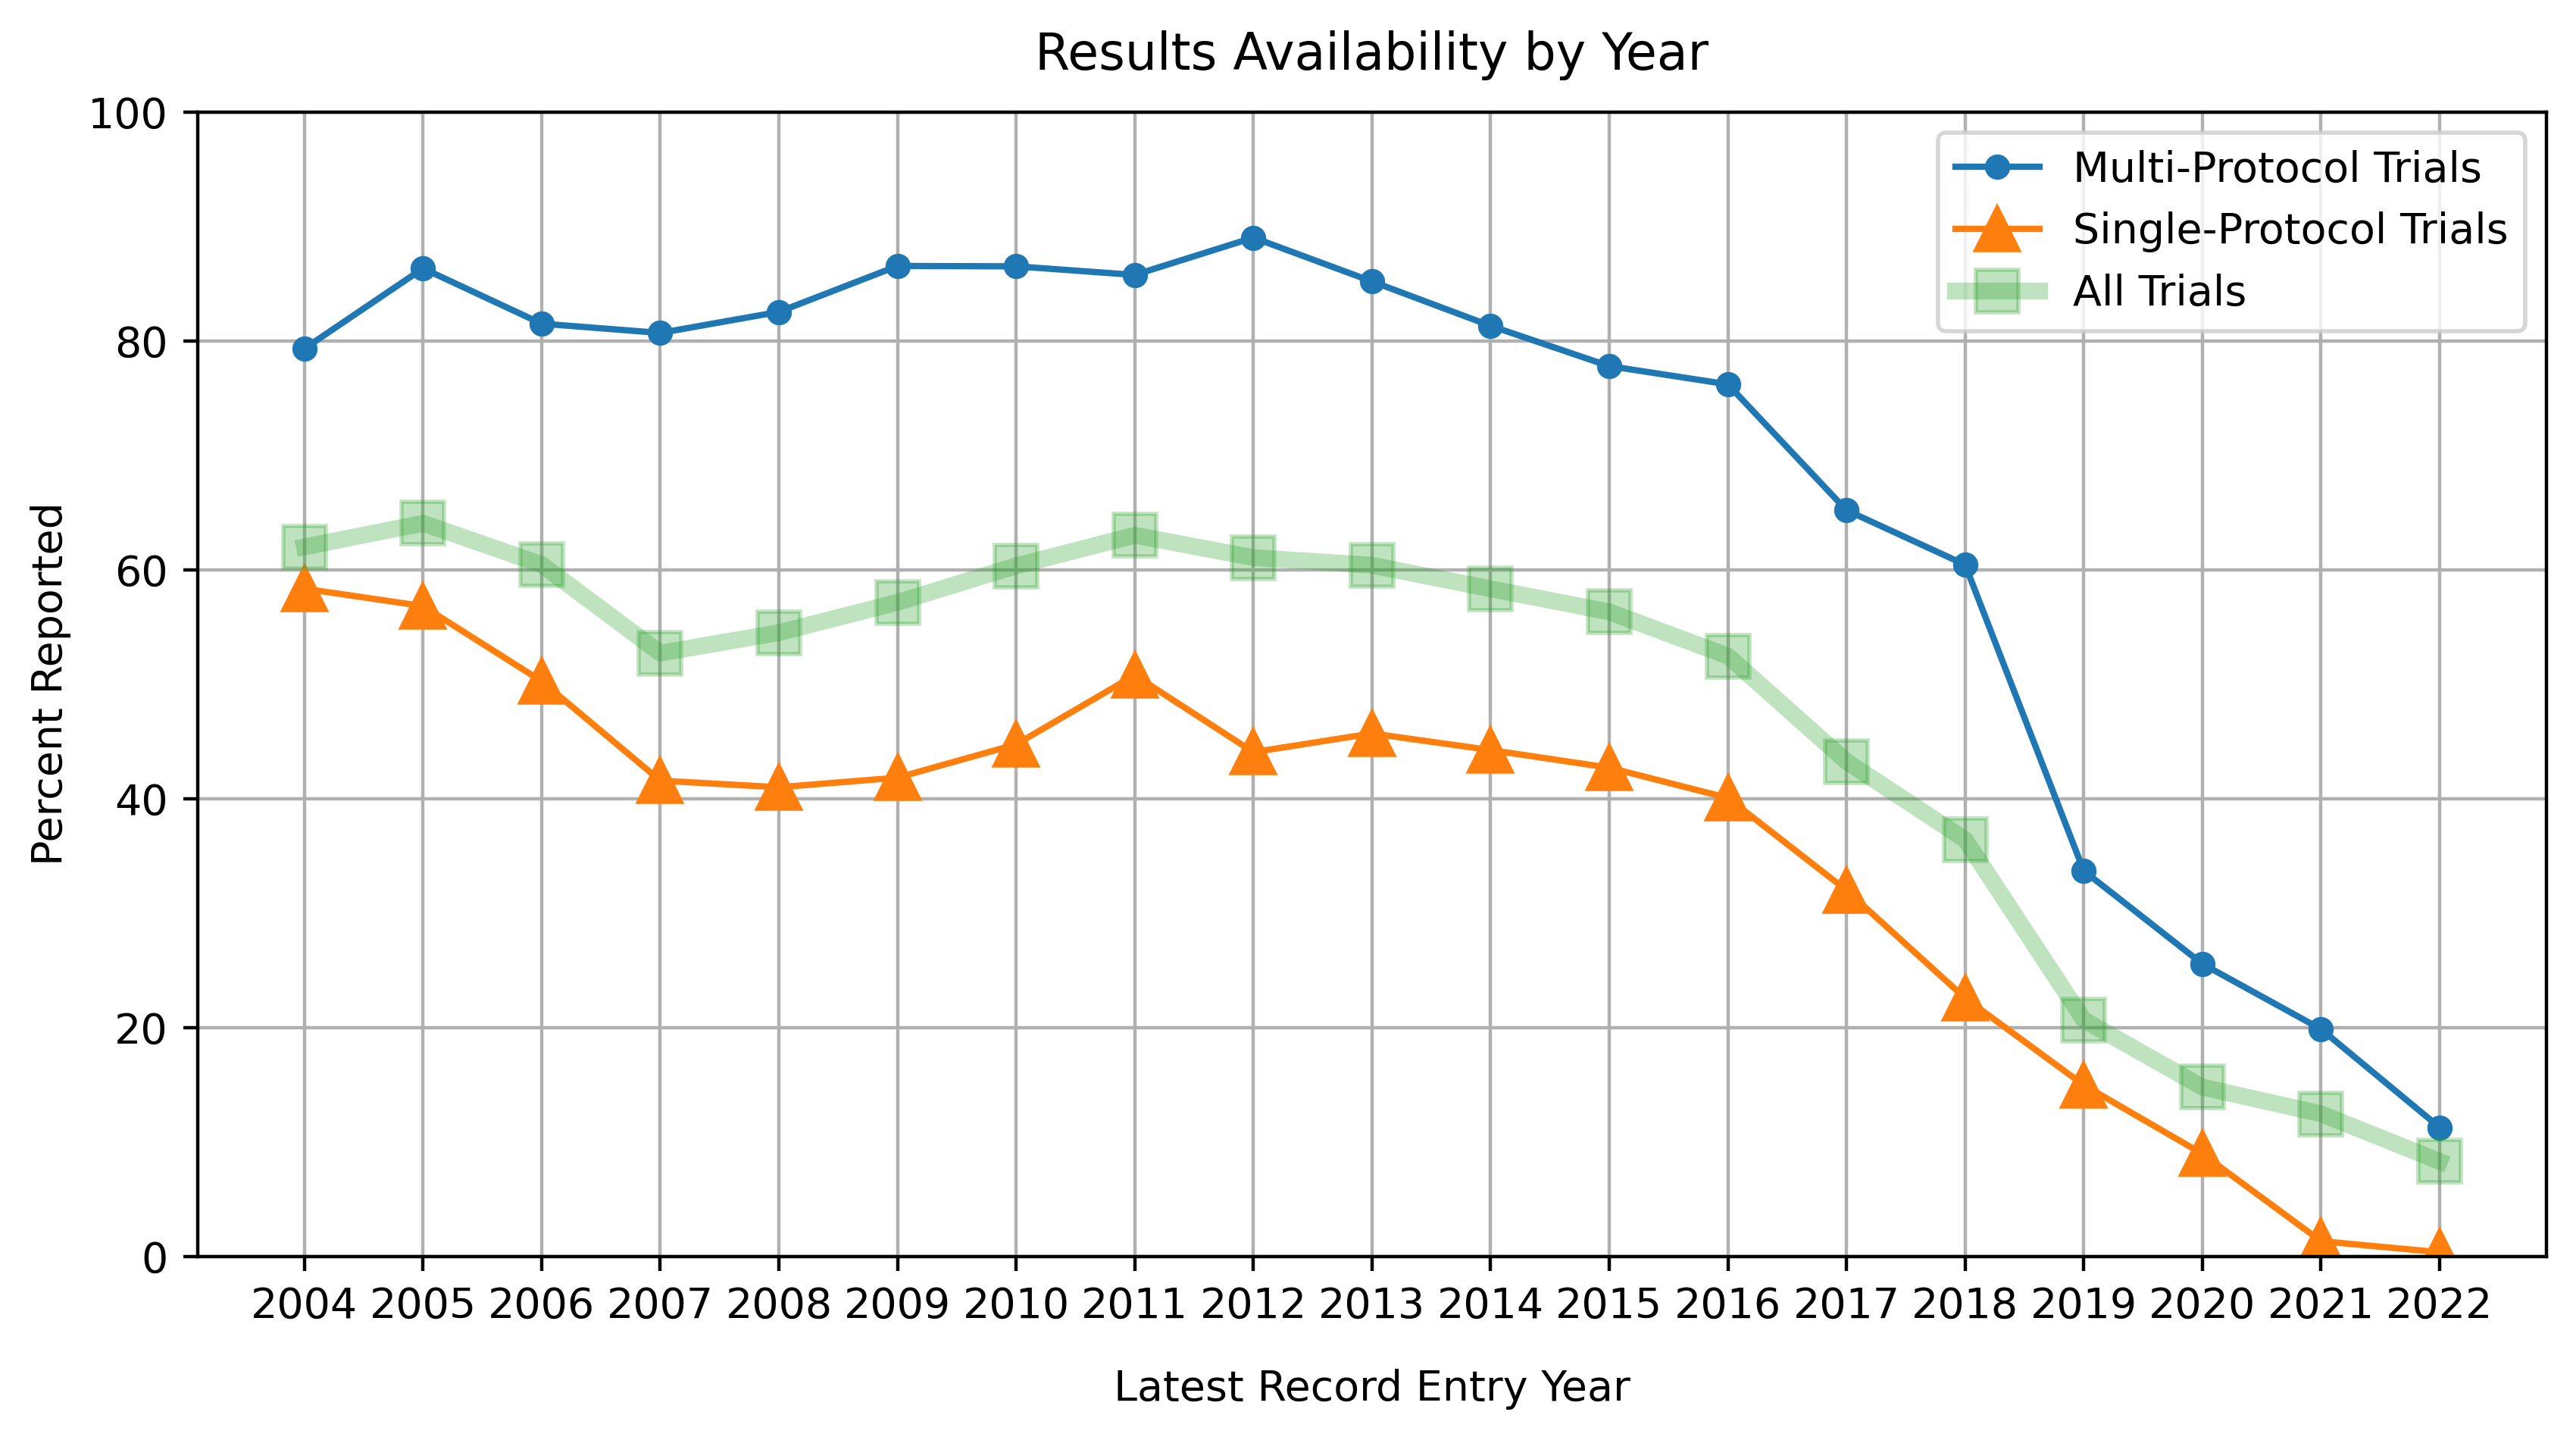

In [29]:
#Graphing the overall trend for single vs multiple CTA trials

fig, ax = plt.subplots(figsize = (10,5), dpi=400)

plt.plot(range(2004,2023), multi_cta['reporting_prct'], marker='.', markersize=10)
plt.plot(range(2004,2023), single_cta['reporting_prct'], marker='^', markersize=10)
plt.plot(range(2004,2023), all_trial_reporting['reporting_prct'], marker='s', markersize=10, lw=4, alpha=.3)

ax.set_xticks(range(2004,2023))

ax.legend(['Multi-Protocol Trials', 'Single-Protocol Trials', 'All Trials'], loc='upper right', fontsize=10)
ax.set_axisbelow(True)
ax.grid(zorder=0)

plt.ylabel('Percent Reported')
plt.xlabel('Latest Record Entry Year', labelpad=10)
plt.ylim(0,100)

plt.title('Results Availability by Year', pad=10)

plt.show()
#fig.savefig(parent + '/data/Figures/fig_s11.jpg', bbox_inches='tight', dpi=400)
#Saved

In [30]:
eu_protocol_count= reporting_by_country.groupby('eudract_number').count()[['nca']].reset_index()

eu_protocol_count.columns = ['eudract_number', 'nca_count']

Creating data for trials with only a single CTA

In [31]:
solo_merge = reporting_by_country.merge(eu_protocol_count, how='left', on='eudract_number')

total = solo_merge[solo_merge.nca_count == 1][['nca', 'entered_year', 'results_dummy']].groupby(['nca', 'entered_year']).count().rename({'results_dummy': 'denominator'}, axis=1)

reported = solo_merge[solo_merge.nca_count == 1][['nca', 'entered_year', 'results_dummy']].groupby(['nca', 'entered_year']).sum().rename({'results_dummy': 'numerator'}, axis=1)

merged = total.join(reported)
merged['unreported'] = merged.denominator - merged.numerator

stacked = merged.drop('denominator', axis=1).stack().unstack(1)

Creating data for trials with multiple CTAs

In [32]:
multi_set = solo_merge[solo_merge.nca_count > 1][['eudract_number', 'results_dummy', 'entered_year']].drop_duplicates()

multi_group = multi_set.groupby('eudract_number', as_index=False).agg('min')[['entered_year', 'results_dummy']].groupby('entered_year').agg({'results_dummy':['count', 'sum']})['results_dummy']
multi_group['prct'] = round((multi_group['sum'] / multi_group['count']) * 100, 2)

Creating for all CTAs

In [33]:
#Get the sum of any NCA with this
stacked.loc['Romania - ANMDM'].sum().sum()

38.0

In [34]:
single_cta_reporting = {}

for x in ordered_countries_new:
    d_r = stacked.loc[x].T
    num = d_r.numerator.sum()
    denom = num + d_r.unreported.sum()
    single_cta_reporting[x] = num / denom

rankings_reporting = pd.Series(single_cta_reporting).sort_values(ascending=False)
rankings_reporting

Latvia - ZVA           0.688889
UK - MHRA              0.659804
Croatia - MIZ          0.625000
Bulgaria - BDA         0.613793
Slovakia - SUKL        0.602564
Germany - BfArM        0.582988
Estonia - SAM          0.553191
Austria - BASG         0.547059
Romania - ANMDM        0.526316
Germany - PEI          0.522500
Lithuania - VVKT       0.474576
Hungary - OGYEI        0.471947
Belgium - FAMHP        0.413919
Czechia - SUKL         0.394410
Poland - URPL          0.385185
Denmark - DKMA         0.380525
Slovenia - JAZMP       0.372549
Greece - EOF           0.346821
Portugal - INFARMED    0.333333
Ireland - HPRA         0.315217
Iceland - IMA          0.275000
Spain - AEMPS          0.243590
Sweden - MPA           0.243083
Finland - FIMEA        0.235474
Italy - AIFA           0.193777
France - ANSM          0.187973
Netherlands - CCMO     0.149893
Norway - NoMA          0.138249
dtype: float64

# Figure 5

In [35]:
#Single CTAs for all NCAs...could turn this into lines as well potentially

fig, axes = plt.subplots(figsize = (20, 16), nrows=7, ncols=4, dpi=400)
#fig.suptitle("Proportion of Single-CTA Trials Reported by Year", y=1.02, fontsize=23)
fig.tight_layout()
for x, y in enumerate(fig.axes):
    stacked.loc[[rankings_reporting.index[x]]].droplevel(level=0).T.plot.bar(stacked=True, ax=y, width=.9, legend=False,
                                                                        sharex='col', rot=45)
    
    y.set_title(rankings_reporting.index[x], pad=6, fontsize=16)
    y.set_axisbelow(True)
    y.grid(axis='y', zorder=0)
    y.set_xlabel('')
    
    hatches = ['','//']
    counter = 0
    h_counter = 0
    patch_count = len(y.patches)
    for p in y.patches:
        p.set_hatch(hatches[h_counter])
        counter += 1
        if counter == ((patch_count/2) * (h_counter+1)):
            h_counter += 1

plt.legend(['Reported', 'Unreported'], 
           loc='lower center', ncol=5, bbox_to_anchor = (-1.25, -.9), fontsize=15)

fig.text(-0.015, 0.5, 'Record Count', ha='center', va='center', rotation='vertical', fontsize=20)
fig.text(.5, -0.02, 'Record Entry Year', ha='center', va='center', fontsize=20)

plt.show()
#fig.savefig(parent + '/data/Figures/fig_5.jpg', bbox_inches='tight', dpi=400)
#fig.savefig(parent + '/data/Figures/fig_5.eps', bbox_inches='tight', dpi=400)
#Saved